## Hourly Scan Pattern Cluster

Aim: Use cluster to idenify difference travel pattern

Fixed Day Count with MaxDayCount to normalize the AvgScan in the dataframe

In [ ]:
## Should ScanType = 1
## StopID is directional, need to find out how
## Possible to classify the StopID to Zone 1, Zone 2, Zone 1 + 2, Free Zone
## Redo this in diff mode
## Have another go with only Train/Tram/Bus CardID

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import os
import time


print(pd.__version__)
print(np.__version__)
print(sns.__version__)


from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans

plt.rcParams["figure.figsize"] = [12,9]

0.23.0
1.14.3
0.8.1


In [2]:
def load_data(the_query, the_file_dir, force_dl = False):
    if not(os.path.isfile(the_file_dir)) or force_dl :
        print('Loading data from BigQuery')
        the_df = pd.read_gbq(the_query,
                             project_id='republic-of-data-2018',
                             private_key="../MelbDatathon2018/Auth/Republic of Data 2018-3f4dcd98a279.json",
                             dialect='standard'
                            )
        the_df.to_hdf(the_file_dir, key='df', mode='w')
    else:
        print('Loading data from local')
        the_df = pd.read_hdf(the_file_dir)
    return(the_df)

In [3]:
query = """
SELECT CardID, Hour, FirstScan, LastScan, ScanCount, AvgScan, DayDiff FROM `republic-of-data-2018.analytics.Weekday_Hourly_Count`
WHERE CardID IN 
(
SELECT CardID FROM `republic-of-data-2018.analytics.Weekday_Hourly_Count`
GROUP BY CardID
HAVING MAX(DayDiff) > 220
)
"""

file_name = '../MelbDatathon2018/Data/scan_hourly_count.h5'

df_scan = load_data(query, file_name)

Loading data from local


In [68]:
df_scan['DayCount'] = df_scan.ScanCount * df_scan.AvgScan

In [74]:
df_MaxDayCount = df_scan.groupby('CardID').max()['DayCount'].reset_index()

In [78]:
df_MaxDayCount.columns = ['CardID', 'MaxDayCount']
df_MaxDayCount.head()

,CardID,MaxDayCount
0,1,9.000000
1,15851,20.000000
2,15990,40.333333
3,16100,36.000000
4,16160,3.000000


In [80]:
df_scan = pd.merge(df_scan, df_MaxDayCount, how = 'left', on=['CardID'])
df_scan['AvgScan'] = df_scan.ScanCount / df_scan.MaxDayCount

In [81]:
df_scan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15337932 entries, 0 to 15337931
Data columns (total 9 columns):
CardID         int64
Hour           int64
FirstScan      datetime64[ns]
LastScan       datetime64[ns]
ScanCount      float64
AvgScan        float64
DayDiff        int64
DayCount       float64
MaxDayCount    float64
dtypes: datetime64[ns](2), float64(4), int64(3)
memory usage: 1.1 GB


In [82]:
df_scan.shape

(15337932, 9)

In [83]:
df_scan.head()

,CardID,Hour,FirstScan,LastScan,ScanCount,AvgScan,DayDiff,DayCount,MaxDayCount
0,9427311,4,2016-01-07,2016-10-03,59.0,0.238354,270,60.017241,247.531250
1,13791760,4,2016-01-21,2018-01-28,103.0,0.083596,738,108.255102,1232.119205
2,15548211,3,2016-02-26,2018-04-27,54.0,0.014050,791,71.121951,3843.408517
3,8397651,2,2016-07-09,2017-09-15,53.0,0.149873,433,78.027778,353.633333
4,5938811,4,2016-08-31,2018-06-08,43.0,0.073407,646,44.023810,585.773006


In [84]:
df_scan.describe()

,CardID,Hour,ScanCount,AvgScan,DayDiff,DayCount,MaxDayCount
count,1.533793e+07,1.533793e+07,1.533793e+07,1.533793e+07,1.533793e+07,1.533793e+07,1.533793e+07
mean,1.347216e+07,1.376518e+01,2.022241e+01,2.316977e-01,2.974362e+02,3.226265e+01,1.423999e+02
std,5.155535e+06,5.233830e+00,5.223684e+01,2.071821e-01,2.846212e+02,1.024595e+02,2.982881e+02
min,1.000000e+00,0.000000e+00,1.000000e+00,3.520386e-05,0.000000e+00,1.000000e+00,2.000000e+00
25%,9.907460e+06,1.000000e+01,2.000000e+00,6.349206e-02,8.000000e+00,3.000000e+00,1.600000e+01
50%,1.415976e+07,1.400000e+01,5.000000e+00,1.712247e-01,2.450000e+02,8.000000e+00,4.096000e+01
75%,1.745283e+07,1.800000e+01,1.600000e+01,3.471074e-01,4.790000e+02,2.400000e+01,1.410667e+02
max,2.254197e+07,2.300000e+01,3.902000e+03,1.000000e+00,1.095000e+03,5.681196e+04,5.681196e+04


In [85]:
df_pivot = df_scan.pivot(index='CardID', columns='Hour', values='AvgScan')

In [86]:
df_pivot.head()

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
CardID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333333,0.222222,0.111111,...,0.222222,0.222222,0.222222,0.666667,NaN,0.333333,NaN,0.222222,NaN,NaN
15851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.050000,0.200000,...,0.600000,0.600000,0.550000,0.450000,0.300000,0.050000,0.050000,0.050000,NaN,0.05000
15990,0.099174,0.024793,NaN,NaN,NaN,NaN,NaN,0.049587,NaN,NaN,...,0.123967,0.099174,0.272727,0.520661,0.545455,0.520661,0.322314,0.247934,0.272727,0.14876
16100,NaN,0.027778,NaN,NaN,NaN,NaN,NaN,NaN,0.055556,NaN,...,0.500000,0.277778,0.083333,0.055556,0.305556,0.166667,0.166667,0.027778,0.083333,NaN
16160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,...,NaN,0.666667,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
df_pivot.fillna(0, inplace=True)

In [88]:
df_pivot.head()

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
CardID,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.222222,0.111111,...,0.222222,0.222222,0.222222,0.666667,0.000000,0.333333,0.000000,0.222222,0.000000,0.00000
15851,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.050000,0.200000,...,0.600000,0.600000,0.550000,0.450000,0.300000,0.050000,0.050000,0.050000,0.000000,0.05000
15990,0.099174,0.024793,0.0,0.0,0.0,0.0,0.0,0.049587,0.000000,0.000000,...,0.123967,0.099174,0.272727,0.520661,0.545455,0.520661,0.322314,0.247934,0.272727,0.14876
16100,0.000000,0.027778,0.0,0.0,0.0,0.0,0.0,0.000000,0.055556,0.000000,...,0.500000,0.277778,0.083333,0.055556,0.305556,0.166667,0.166667,0.027778,0.083333,0.00000
16160,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.666667,...,0.000000,0.666667,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [89]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1124525 entries, 1 to 22541971
Data columns (total 24 columns):
0     1124525 non-null float64
1     1124525 non-null float64
2     1124525 non-null float64
3     1124525 non-null float64
4     1124525 non-null float64
5     1124525 non-null float64
6     1124525 non-null float64
7     1124525 non-null float64
8     1124525 non-null float64
9     1124525 non-null float64
10    1124525 non-null float64
11    1124525 non-null float64
12    1124525 non-null float64
13    1124525 non-null float64
14    1124525 non-null float64
15    1124525 non-null float64
16    1124525 non-null float64
17    1124525 non-null float64
18    1124525 non-null float64
19    1124525 non-null float64
20    1124525 non-null float64
21    1124525 non-null float64
22    1124525 non-null float64
23    1124525 non-null float64
dtypes: float64(24)
memory usage: 214.5 MB


In [90]:
df_pivot.shape

(1124525, 24)

### Scipy Hierarchial Clustering

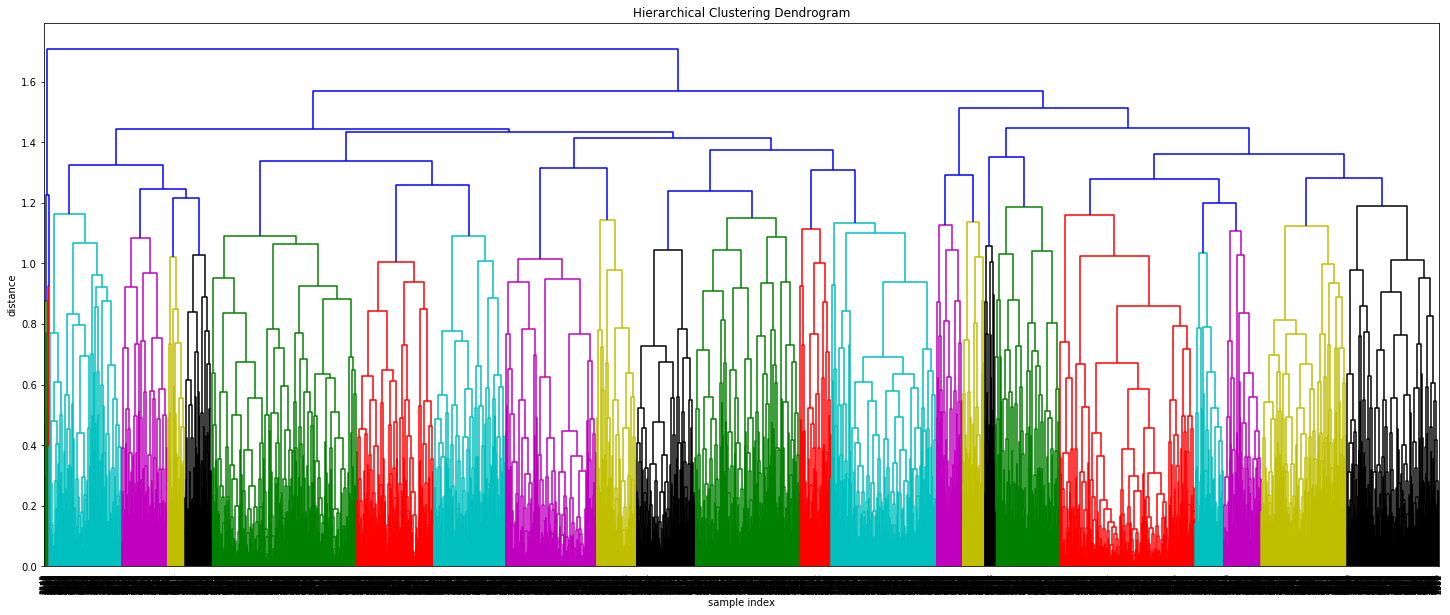

In [91]:
# Do the clustering
Z = hac.linkage(df_pivot.sample(5000, random_state=101), method='complete', metric='correlation')

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

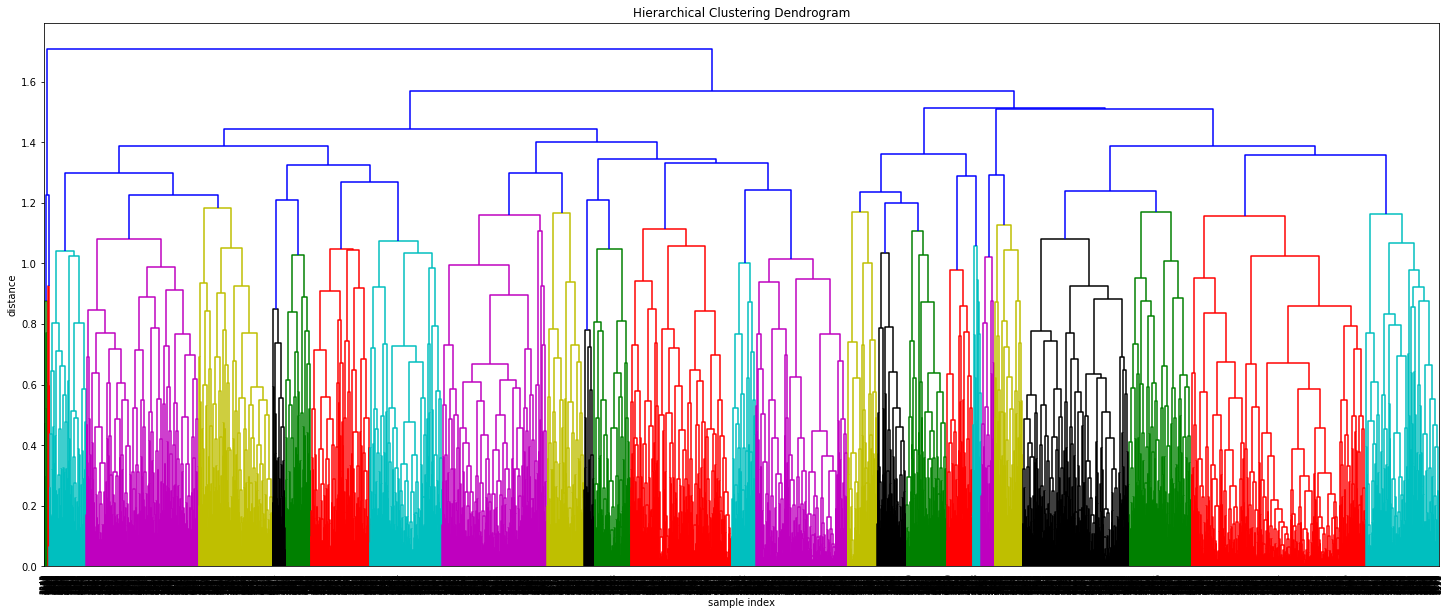

In [93]:
# Here we use spearman correlation
def my_metric(x, y):
    r = stats.pearsonr(x, y)[0]
    return 1 - r # correlation to distance: range 0 to 2

# Do the clustering    
Z = hac.linkage(df_pivot.sample(5000, random_state=101),  method='complete', metric=my_metric)

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [94]:
from scipy.cluster.hierarchy import fcluster

def print_clusters(timeSeries, Z, k, plot=False):
    # k Number of clusters I'd like to extract
    results = fcluster(Z, k, criterion='maxclust')

    # check the results
    s = pd.Series(results)
    clusters = s.unique()

    for c in range(1,(len(clusters)+1)):
        cluster_indeces = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
        if plot:
            plt.subplot(2,2,1)
            df_pivot.sample(5000, random_state=101).T.iloc[:,cluster_indeces].plot(legend = None, ax=plt.gca())
            plt.subplot(2,2,2)
            df_pivot.sample(5000, random_state=101).T.iloc[:,cluster_indeces].mean(axis = 1).plot(legend = None, ax=plt.gca())
            plt.show()
print_clusters(df_pivot.sample(5000, random_state=101), Z, 8, plot=False)

Cluster 1 number of entries 18
Cluster 2 number of entries 1409
Cluster 3 number of entries 509
Cluster 4 number of entries 943
Cluster 5 number of entries 479
Cluster 6 number of entries 149
Cluster 7 number of entries 605
Cluster 8 number of entries 888


Cluster 1 number of entries 18


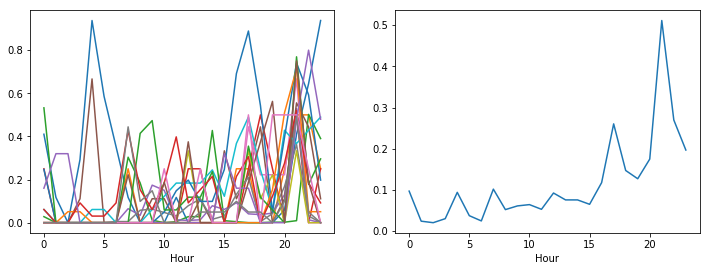

Cluster 2 number of entries 1409


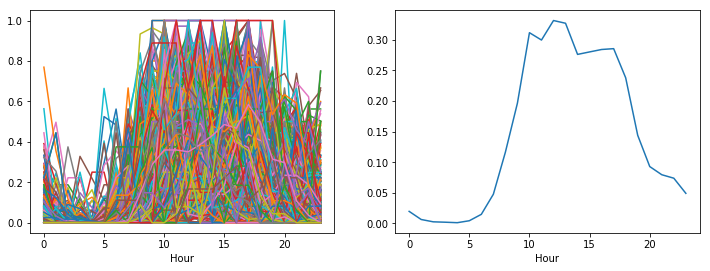

Cluster 3 number of entries 509


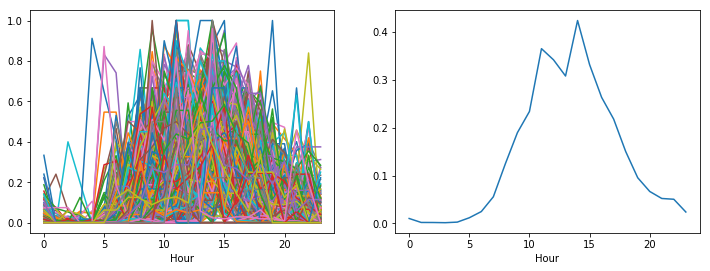

Cluster 4 number of entries 943


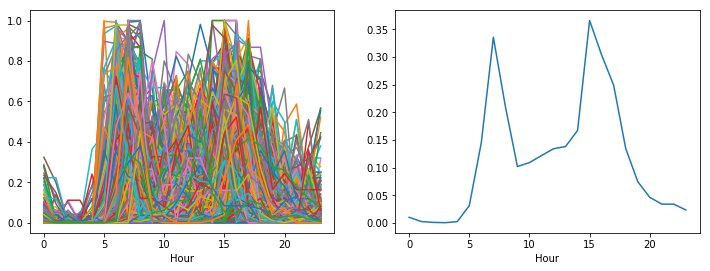

Cluster 5 number of entries 479


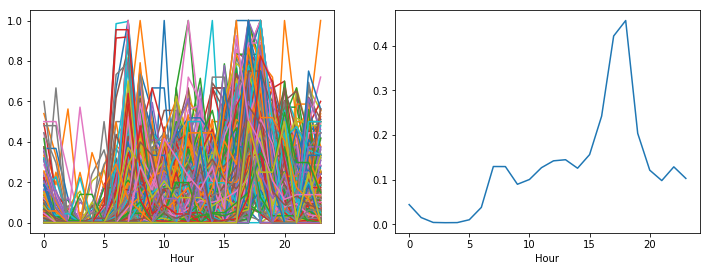

Cluster 6 number of entries 149


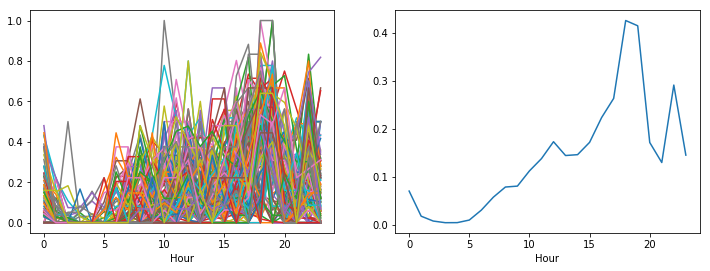

Cluster 7 number of entries 605


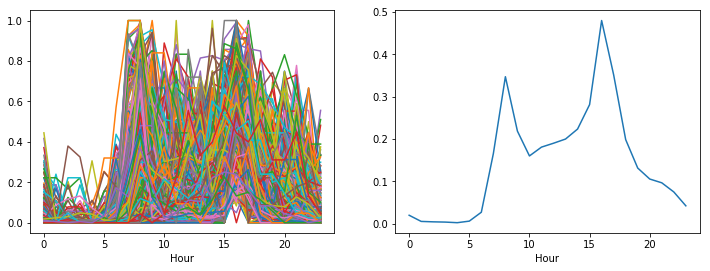

Cluster 8 number of entries 888


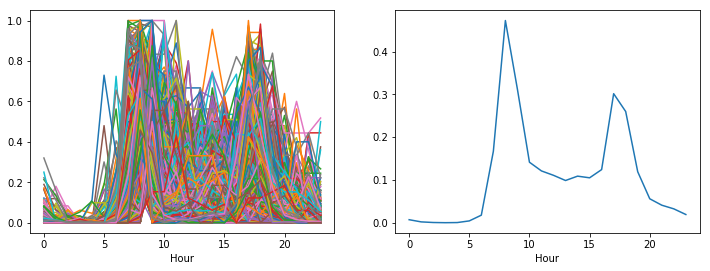

In [100]:
print_clusters(df_pivot.sample(5000, random_state=101), Z, 8, plot=True)

### SciKit Learn

Shouldn't use this method anyway, KMeans isn't really for time series

In [21]:
df_train = df_pivot.sample(20000, random_state=101)
dict_ss = {}
for num in range(3,10):    
    print('Running' + str(num).rjust(3) + ' clusters')
    kmeans = KMeans(n_clusters = num, random_state = 101).fit(df_train)
    kmeans_lable = kmeans.labels_
    #list_ss.append(metrics.silhouette_score(df_train, kmeans_lable, metric = 'euclidean'))
    dict_ss[str(num)] = metrics.silhouette_score(df_train, kmeans_lable, metric = 'euclidean')

Running  3 clusters
Running  4 clusters
Running  5 clusters
Running  6 clusters
Running  7 clusters
Running  8 clusters
Running  9 clusters


In [22]:
print("Best number of cluster:")
print(max(dict_ss, key = dict_ss.get))
print("Silhouette Score:")
print(dict_ss[max(dict_ss, key = dict_ss.get)])

Best number of cluster:
3
Silhouette Score:
0.10283638443870113


### KMean for TS

One way to use KMeans for time series, but need to write from scractch

In [ ]:
def init_centroids(data, num_clust):
    centroids = np.zeros([num_clust, data.shape[1]]) 
    centroids[0,:] = data[np.random.randint(0, data.shape[0], 1)]

    for i in range(1, num_clust):
        D2 = np.min([np.linalg.norm(data - c, axis = 1)**2 for c in centroids[0:i, :]], axis = 0) 
        probs = D2/D2.sum()
        cumprobs = probs.cumsum()
        ind = np.where(cumprobs >= np.random.random())[0][0]
        centroids[i, :] = np.expand_dims(data[ind], axis = 0)

    return centroids

def k_means(data, num_clust, num_iter): 
    centroids = init_centroids(data, num_clust)
    last_centroids = centroids

    for n in range(num_iter):
        closest = closest_centroids(data, centroids)
        centroids = move_centroids(data, closest, centroids)
        if not np.any(last_centroids != centroids):
            print("Early finish!")
            break
        last_centroids = centroids
    return centroids

def closest_centroids(data, centroids): 
    dist = calc_centroids(data, centroids) 
    return np.argmin(dist, axis = 1)

def calc_centroids(data, centroids):
    dist = np.zeros([data.shape[0], centroids.shape[0]])
    for idx, centroid in enumerate(centroids): 
        dist[:, idx] = euclid_dist(centroid, data)
    return np.array(dist)

def euclid_dist(t1, t2):
         return np.sqrt(((t1-t2)**2).sum())
    
def move_centroids(data, closest, centroids):
    k = centroids.shape[0]
    new_centroids = np.array([data[closest == c].mean(axis = 0) for c in np.unique(closest)])

    if k - new_centroids.shape[0] > 0:
       print("adding {} centroid(s)".format(k - new_centroids.shape[0]))
       additional_centroids = data[np.random.randint(0, data.shape[0], k - new_centroids.shape[0])] 
       new_centroids = np.append(new_centroids, additional_centroids, axis = 0)

    return new_centroids

In [ ]:
t1 = time.time()
centroids = k_means(df_pivot.values, 10, 20)
t2 = time.time()
print("Took {} seconds".format(t2 - t1))